In [1]:
import os
import dotenv
import unicodedata
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltgr

In [2]:
def limpiaTexto(texto):
    if not isinstance(texto, str):
        return texto
    # Proteger la ñ y Ñ con un marcador temporal
    texto = texto.replace('ñ', '__enie__').replace('Ñ', '__ENIE__')
    # Quitar tildes
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )
    # Restaurar la ñ y Ñ
    return texto.replace('__enie__', 'ñ').replace('__ENIE__', 'Ñ')

In [3]:
def limpiaComunas(texto):
    if not isinstance(texto, str):
        return texto
    coma_pos = texto.find(",")
    if coma_pos != -1:
        tfinal = texto[:coma_pos].lower()
        x = tfinal.find("de chile")
        if x != -1:
            tfinal = tfinal[:x].strip()
        return tfinal
    elif texto.lower().find("santiago") != -1:
        return texto.lower().replace("santiago -", "").strip()
    elif texto.lower().find("- santiago") != -1:
        return texto.lower().replace("- santiago", "").strip()
    return texto.lower()

In [4]:
# Ajustar la cantidad máxima de filas y columnas para mostrar
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

In [5]:
dotenv.load_dotenv()
path_csv = os.getenv("CSV_CHILETRABAJOS")
path_csv2 = os.getenv("CSV_COMPUTRABAJO")
path_csv3 = os.getenv("CSV_INDEED")

try:
    df = pd.read_csv(path_csv,sep=";",encoding="utf-8")
    print("Datos de 'chiletrabajos.com' cargados.")
    # Limpia caracteres de ofertas
    #df['Oferta'] = df['Oferta'].apply(limpiaTexto)
    display(df.head())
except Exception as e:
        print(f"error :{e}")
        
try:
    df2 = pd.read_csv(path_csv2,sep=",",encoding="utf-8")
    print("datos 'computrabajo.com' cargados")
    #df2['Cargo'] = df2['Cargo'].apply(limpiaTexto)
    display(df2.head())
except Exception as e:
        print(f"error :{e}")

try:
    df3 = pd.read_csv(path_csv3,sep=";",encoding="utf-8")
    print("datos 'indeed.com' cargados")
    display(df3.head())
except Exception as e:
        print(f"error :{e}")

Datos de 'chiletrabajos.com' cargados.


,Oferta,Salario,Beneficios,Empresa,Descripcion,Ubicacion,Fecha_Publicacion,Fecha_Expiracion
0,INGENIERO DE SOFTWARE – BLAZOR WEBASSEMBLY .NE...,a convenir,-La empresa paga o copaga una cobertura de sal...,Grupo-O2,En GRUPO O2 busca Ingeniero de Software – Blaz...,Santiago,2025-03-24 10:24:32,2025-06-07 (en 75 días)
1,INGENIERO DE SOFTWARE – FRONTEND REACT Y BACKE...,a convenir,-La empresa paga o copaga una cobertura de sal...,GRUPO-o2,En GRUPO O2 busca Ingeniero de Software – Fron...,Santiago,2025-03-24 10:28:38,2025-06-07 (en 75 días)
2,AYUDANTE CONDUCTOR,NaN,-¡La salud es lo más importante! La empresa pa...,Reclutamiento XR3,En XR3 nos encontramos buscando a nuestro prox...,Illapel,2025-03-22 12:02:01,2025-06-05 (en 73 días)
3,DISEÑADOR UX UI (REMOTO),NaN,-La empresa paga o copaga una cobertura de sal...,Kibernum,¡Únete a nuestro equipo como Diseñador UX UI p...,Santiago,2025-03-21 11:42:15,2025-06-04 (en 72 días)
4,INGENIERO CLOUD OPS,Negociable,-La empresa paga o copaga una cobertura de sal...,Kabeli Selección,Kabeli se encuentra en búsqueda de un Ingenier...,Santiago,2025-03-21 16:03:14,2025-06-04 (en 72 días)


datos 'computrabajo.com' cargados


,Salario,Empresa,Comuna,Región,Cargo,Descripción
0,NaN,SoluNegocios,Santiago Centro,Metropolitana,Vendedor de Servicios BPO,Holding con más de 20 años de presencia consol...
1,NaN,Softtek Chile,Las condes,Metropolitana,Desarrollador .Net Senior - (con portugués),Licenciatura en Tecnología de la Información o...
2,NaN,People GO,Santiago Centro,Metropolitana,KAM (experiencia sector Industrial) – Santiago,"Somos People Go, empresa al Servicio de las Pe..."
3,750000.0,Grafton Recruitment Chile,Las condes,Metropolitana,"Auxiliar de Farmacia Lo Fontecilla, Las Condes",¡ÚNETE A GRUPO GRAFTON! Buscamos Auxiliares d...
4,NaN,Genesys Ltda.,Santiago Centro,Metropolitana,"Desarrollador Back End - Java, Python o GO","Somos una empresa con 34 años en el mercado, e..."


datos 'indeed.com' cargados


,oferta,salario,empresa,descripcion,ubicacion
0,"""Asistente de informática (Santiago)""",NaN,Salmonjobs,Estamos en búsqueda de un/a Asistente de Infor...,"Santiago de Chile, Región Metropolitana"
1,"""Practica profesional Informática""",NaN,Applicant AI,Responsabilidades del practicante:\nConfigurac...,"Santiago de Chile, Región Metropolitana"
2,"""ENCARGADO TECNOLOGIA E INFORMATICA (TI)""",NaN,Confidencial,REALIZAR BACKUP\nSUPERVISAR CONEXIONES\nCONFIG...,"Santiago de Chile, Región Metropolitana"
3,"""Soporte Informático""",NaN,NEWREST CHILE,NEWREST empresa multinacional francesa de serv...,"Puerto Montt, Los Lagos"
4,"""Técnico en soporte Informático – Remoto (Ofe...",NaN,CLÍNICA MEDICAL HOME,Clínica medical home nos encontramos en búsque...,"Santiago de Chile, Región Metropolitana"


In [6]:
# Contamos las ofertas por ubicación en cada dataframe
tabla_ciudades_ct = df['Ubicacion'].value_counts().reset_index()
tabla_ciudades_ct.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_ct['Ciudad/Comuna'] = tabla_ciudades_ct['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_comput = df2['Comuna'].value_counts().reset_index()
tabla_ciudades_comput.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_comput['Ciudad/Comuna'] = tabla_ciudades_comput['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_indeed = df3['ubicacion'].value_counts().reset_index()
tabla_ciudades_indeed.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_indeed['Ciudad/Comuna'] = tabla_ciudades_indeed['Ciudad/Comuna'].apply(limpiaComunas)
tabla_ciudades_total = pd.concat([tabla_ciudades_ct, tabla_ciudades_comput, tabla_ciudades_indeed], ignore_index=True)
# Agrupamos por ciudad y sumamos la cantidad de ofertas
tabla_ciudades_total = tabla_ciudades_total.groupby('Ciudad/Comuna', as_index=False).sum()
# Ordenamos por cantidad de ofertas de mayor a menor
tabla_ciudades_total = tabla_ciudades_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla
print("Total de ofertas por ciudad\n")
print(print(tabla_ciudades_total.to_string(index=False)))



Total de ofertas por ciudad

      Ciudad/Comuna  Cantidad_Ofertas
           santiago              1475
         las condes               259
        antofagasta               158
    santiago centro               151
        providencia               136
           pudahuel                89
         concepción                71
           rancagua                62
          quilicura                54
         valparaíso                52
         huechuraba                42
            iquique                41
              ñuñoa                41
             calama                39
            copiapó                38
       puerto montt                32
       san bernardo                29
              maipú                29
              talca                28
       viña del mar                27
          la serena                24
              lampa                22
             temuco                21
        puente alto                18
         la florida  

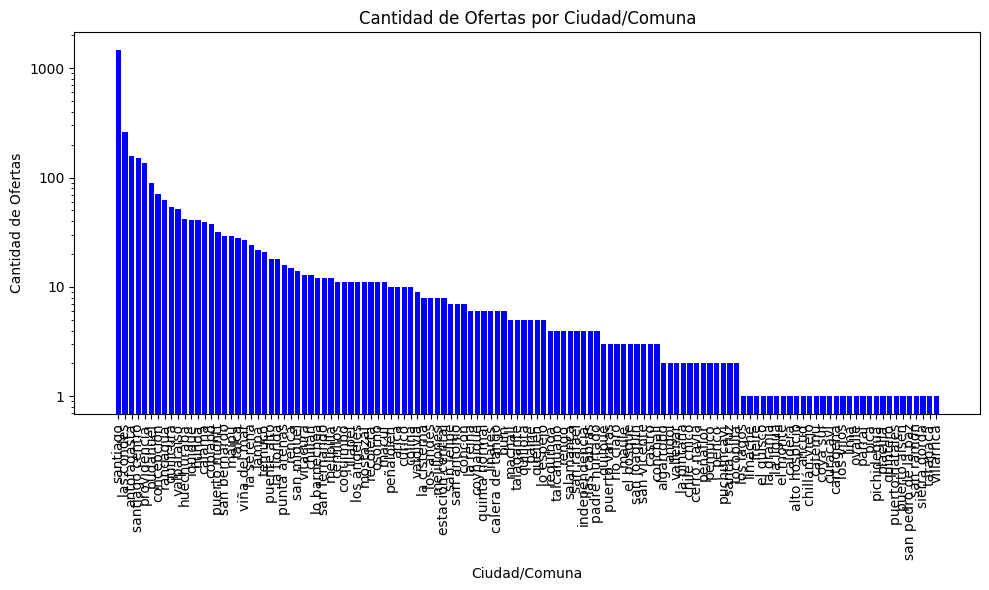

In [7]:
from matplotlib.ticker import FuncFormatter
pltgr.figure(figsize=(10, 6))
pltgr.bar(tabla_ciudades_total['Ciudad/Comuna'], tabla_ciudades_total['Cantidad_Ofertas'], color='blue')
pltgr.yscale('log')  # Escala logarítmica en el eje y

# Personalizar las etiquetas del eje y
formatter = FuncFormatter(lambda y, _: f'{int(y)}')
pltgr.gca().yaxis.set_major_formatter(formatter)
pltgr.xlabel('Ciudad/Comuna')
pltgr.ylabel('Cantidad de Ofertas')
pltgr.title('Cantidad de Ofertas por Ciudad/Comuna')
pltgr.xticks(rotation=90)
pltgr.tight_layout()
pltgr.show()

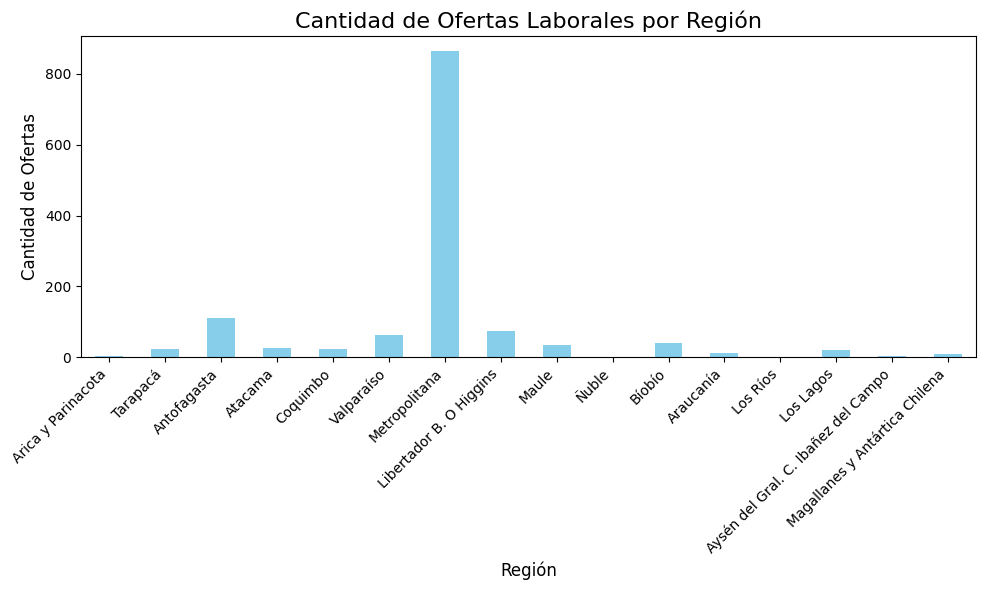

In [8]:
# Definimos el orden geográfico de las regiones de norte a sur
orden_regiones = [
    'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 
    'Valparaíso', 'Metropolitana', 'Libertador B. O Higgins', 'Maule', 'Ñuble', 'Bíobío', 
    'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén del Gral. C. Ibañez del Campo', 'Magallanes y Antártica Chilena'
]

# Aseguramos que las regiones estén en el orden correcto
df2['Región'] = pd.Categorical(df2['Región'], categories=orden_regiones, ordered=True)

# Contamos la cantidad de ofertas por región
ofertas_por_region = df2['Región'].value_counts().sort_index()

# Creamos el gráfico
pltgr.figure(figsize=(10, 6))
ofertas_por_region.plot(kind='bar', color='skyblue')

# Cambiar la escala del eje y a logaritmica para mejorar la visibilidad
#pltgr.yscale('log')

# Personalizamos el gráfico
pltgr.title('Cantidad de Ofertas Laborales por Región', fontsize=16)
pltgr.xlabel('Región', fontsize=12)
pltgr.ylabel('Cantidad de Ofertas', fontsize=12)
pltgr.xticks(rotation=45, ha='right')
pltgr.tight_layout()

# Mostramos el gráfico
pltgr.show()

In [9]:
# Filtrar ofertas con salarios en cada dataframe
ofertas_con_salario_ct = df[df['Salario'].notnull()]
ofertas_con_salario_comput = df2[df2['Salario'].notnull()]
ofertas_con_salario_indeed = df3[df3['salario'].notnull()]

import re
def es_salario_valido(salario):
    if isinstance(salario, str):
        return bool(re.match(r'^\d+(\.\d+)?$', salario))
    return False


# Eliminar puntos en los valores de la columna 'Salario' si los detecta
ofertas_con_salario_ct['Salario'] = ofertas_con_salario_ct['Salario'].str.replace('.', '', regex=False)


## Chiletrabajos df
ofertas_con_salario_ct = ofertas_con_salario_ct[ofertas_con_salario_ct['Salario'].apply(es_salario_valido)]


## indeed csv 
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.replace("por mes", "", regex=False).str.replace("$", "", regex=False).str.replace(".","").str.strip()
# Eliminar salarios que tienen solo números iguales

# Separar en dos filas si hay un "-"
ofertas_con_salario_indeed = ofertas_con_salario_indeed.assign(salario=ofertas_con_salario_indeed['salario'].str.split('-')).explode('salario')
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.strip()

# Filtrar las filas que contienen "por hora" en la columna salario
ofertas_con_salario_indeed = ofertas_con_salario_indeed[~ofertas_con_salario_indeed['salario'].str.contains("por hora", na=False)]
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.replace(".","")

## Computrabajo df2
# Eliminar el .0 de los valores de salario en df2
ofertas_con_salario_comput['Salario'] = ofertas_con_salario_comput['Salario'].astype(str).str.replace('.0', '', regex=False).str.strip()

# Limpiar las comunas en cada dataframe de ofertas con salario
ofertas_con_salario_ct['Ubicacion'] = ofertas_con_salario_ct['Ubicacion'].apply(limpiaComunas)
ofertas_con_salario_comput['Comuna'] = ofertas_con_salario_comput['Comuna'].apply(limpiaComunas)
ofertas_con_salario_indeed['ubicacion'] = ofertas_con_salario_indeed['ubicacion'].apply(limpiaComunas)

# Convertir las columnas de salario a tipo numérico, manejando errores
ofertas_con_salario_ct['Salario'] = pd.to_numeric(ofertas_con_salario_ct['Salario'], errors='coerce')
ofertas_con_salario_comput['Salario'] = pd.to_numeric(ofertas_con_salario_comput['Salario'], errors='coerce')
ofertas_con_salario_indeed['salario'] = pd.to_numeric(ofertas_con_salario_indeed['salario'], errors='coerce')

# Eliminar salarios que contengan números iguales o
ofertas_con_salario_ct = ofertas_con_salario_ct[~ofertas_con_salario_ct['Salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_ct = ofertas_con_salario_ct[ofertas_con_salario_ct['Salario'] >= 100000]

ofertas_con_salario_comput = ofertas_con_salario_comput[~ofertas_con_salario_comput['Salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_comput = ofertas_con_salario_comput[ofertas_con_salario_comput['Salario'] >= 1000000]

ofertas_con_salario_indeed = ofertas_con_salario_indeed[~ofertas_con_salario_indeed['salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_indeed = ofertas_con_salario_indeed[ofertas_con_salario_indeed['salario'] >= 1000000]

# Calcular el promedio de salarios por ciudad/comuna
promedio_salarios_ct = ofertas_con_salario_ct.groupby('Ubicacion')['Salario'].mean().reset_index()
promedio_salarios_ct.columns = ['Ciudad/Comuna', 'Promedio_Salario']

promedio_salarios_comput = ofertas_con_salario_comput.groupby('Comuna')['Salario'].mean().reset_index()
promedio_salarios_comput.columns = ['Ciudad/Comuna', 'Promedio_Salario']

promedio_salarios_indeed = ofertas_con_salario_indeed.groupby('ubicacion')['salario'].mean().reset_index()
promedio_salarios_indeed.columns = ['Ciudad/Comuna', 'Promedio_Salario']

# Concatenar los promedios de salarios de los tres dataframes
promedio_salarios_total = pd.concat([promedio_salarios_ct, promedio_salarios_comput, promedio_salarios_indeed], ignore_index=True)

# Agrupar por ciudad/comuna y calcular el promedio final
promedio_salarios_total = promedio_salarios_total.groupby('Ciudad/Comuna', as_index=False).mean()

# Mostrar el resultado
print("Promedio de salarios por ciudad/comuna\n")
print(promedio_salarios_total.to_string(index=False))
# Filtrar los valores de salarios de Valparaíso



Promedio de salarios por ciudad/comuna

   Ciudad/Comuna  Promedio_Salario
     antofagasta      1.395912e+06
           arica      7.798333e+05
          calama      1.249900e+06
     cerro navia      1.800000e+06
         chillán      5.830554e+06
          colina      9.337500e+05
      concepción      9.030381e+05
          concón      1.034799e+06
         copiapó      1.323333e+06
        coquimbo      5.150000e+05
       coyhaique      5.500000e+05
          curicó      1.200000e+06
estación central      1.500000e+06
      huechuraba      1.462500e+06
         illapel      8.500000e+05
   independencia      1.500000e+06
         iquique      5.500000e+05
     la cisterna      1.100000e+06
        la reina      1.000000e+06
       la serena      6.250000e+05
           lampa      1.303200e+06
      las condes      1.452083e+06
         linares      7.500000e+05
    lo barnechea      2.700000e+06
       los andes      1.200000e+06
     los ángeles      7.000000e+05
           macu

/tmp/ipykernel_8758/771532322.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ofertas_con_salario_ct['Salario'] = ofertas_con_salario_ct['Salario'].str.replace('.', '', regex=False)
/tmp/ipykernel_8758/771532322.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.replace("por mes", "", regex=False).str.replace("$", "", regex=False).str.replace(".","").str.strip()
/tmp/ipykernel_8758/771532322.py:35: SettingWithCopyWarnin

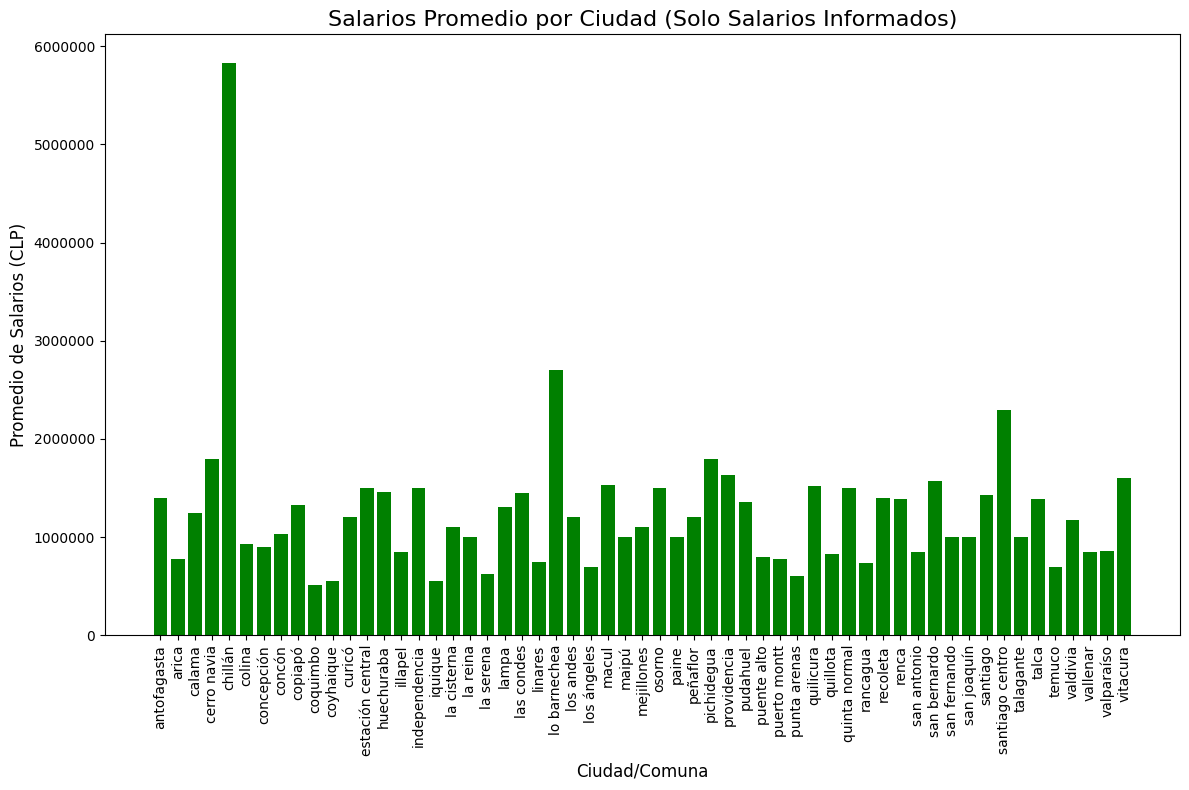

In [10]:
# Gráfico de salarios promedio por ciudad
pltgr.figure(figsize=(12, 8))
pltgr.bar(promedio_salarios_total['Ciudad/Comuna'], promedio_salarios_total['Promedio_Salario'], color='green')

# Configuración del gráfico
pltgr.title('Salarios Promedio por Ciudad (Solo Salarios Informados)', fontsize=16)
pltgr.xlabel('Ciudad/Comuna', fontsize=12)
pltgr.ylabel('Promedio de Salarios (CLP)', fontsize=12)
pltgr.xticks(rotation=90, fontsize=10)

# Evitar notación científica en el eje Y
pltgr.ticklabel_format(style='plain', axis='y')

pltgr.tight_layout()

# Mostrar el gráfico
pltgr.show()

In [11]:
def clasificar_puesto(oferta):
    oferta = str(oferta).lower()
    if ('fullstack' or 'full stack'or 'full-stack') in oferta:
        return 'Fullstack'
    elif ('frontend' or 'front end' or 'front-end') in oferta:
        return 'Frontend'
    elif ('backend' or 'back end' or 'back-end' or 'sql') in oferta:
        return 'Backend'
    elif 'analista' in oferta:
        return 'Analista'
    elif 'devops' in oferta:
        return 'DevOps'
    elif ('qa' or 'tester') in oferta:
        return 'QA'
    elif ('data' or 'analista de datos' or 'bigdata' or 'big data' or 'datos' or 'data scientist') in oferta:
        return 'Data Scientist'
    elif ('ciberseguridad'or 'seguridad' or 'ethical hacking') in oferta:
        return 'Ciberseguridad'
    elif ('mobile' or 'movil'or 'android' or 'ios') in oferta:
        return 'Mobile'
    elif ('ux' or 'ui') in oferta:
        return 'UX/UI'
    elif ('machine learning engineer' or 'ia') in oferta:
        return 'Ingeniero de IA'
    elif ('arquitecto' or 'arquitecta' or 'arquitecto de software') in oferta:
        return 'Arquitecto de Software'
    elif ('consultor' or 'consultora' or 'consulting') in oferta:
        return 'Consultor'
    elif ('lider' or 'scrum master' or 'scrum-master' or 'jefe de proyectos' or 'jefe de proyecto' or 'proyect manager') in oferta:
        return 'Lider de proyecto'
    elif ('desarrollador' or 'developer' or 'programador' or 'ingeniero de software' or 'ejecucion') in oferta:
        return 'Developer'
    elif ('soporte' or 'mantenimiento')in oferta:
        return 'Soporte Técnico'
    elif 'cloud' in oferta:
        return 'Cloud'
    elif 'tecnico' in oferta:
        return 'Técnico'
    elif 'practica' in oferta:
        return 'Práctica Profesional'
    elif ('administrador' or 'gestor') in oferta:
        return 'Administrador'
    elif ('redes' or 'comunicaciones' or 'telecomunicaciones') in oferta:
        return 'Redes'
    elif ('business intelligence' or 'bi') in oferta:
        return 'Business Intelligence'
    elif ('sistemas' or 'infraestructura' or 'infraestructura de sistemas') in oferta:
        return 'Especialista en Sistemas'
    
    else:
        return 'Otros'

df['Puesto'] = df['Oferta'].apply(clasificar_puesto)
df2['Puesto'] = df2['Cargo'].apply(clasificar_puesto)
df3['Puesto'] = df3['oferta'].apply(clasificar_puesto)
tabla_puestos_indeed = df3['Puesto'].value_counts().reset_index()
tabla_puestos_comput = df2['Puesto'].value_counts().reset_index()
tabla_puestos = df['Puesto'].value_counts().reset_index()
tabla_puestos.columns = ['Puesto', 'Cantidad_Ofertas']
tabla_puestos_comput.columns = ['Puesto', 'Cantidad_Ofertas']
tabla_puestos_indeed.columns = ['Puesto', 'Cantidad_Ofertas']


In [12]:
# data frames de ofertas con salario
# ofertas_con_salario_ct , ofertas_con_salario_comput, ofertas_con_salario_indeed
# Crear tablas de promedio de salarios por tipo de puesto
# Aplicar la función clasificar_puesto a las tablas de ofertas con salario
ofertas_con_salario_ct['Puesto'] = ofertas_con_salario_ct['Oferta'].apply(clasificar_puesto)
ofertas_con_salario_comput['Puesto'] = ofertas_con_salario_comput['Cargo'].apply(clasificar_puesto)
ofertas_con_salario_indeed['Puesto'] = ofertas_con_salario_indeed['oferta'].apply(clasificar_puesto)
promedio_salarios_ct_puesto = ofertas_con_salario_ct.groupby('Puesto')['Salario'].mean().reset_index()
promedio_salarios_ct_puesto.columns = ['Puesto', 'Promedio_Salario']

promedio_salarios_comput_puesto = ofertas_con_salario_comput.groupby('Puesto')['Salario'].mean().reset_index()
promedio_salarios_comput_puesto.columns = ['Puesto', 'Promedio_Salario']

promedio_salarios_indeed_puesto = ofertas_con_salario_indeed.groupby('Puesto')['salario'].mean().reset_index()
promedio_salarios_indeed_puesto.columns = ['Puesto', 'Promedio_Salario']

# Concatenar las tablas de promedio de salarios
promedio_salarios_puesto_total = pd.concat(
    [promedio_salarios_ct_puesto, promedio_salarios_comput_puesto, promedio_salarios_indeed_puesto],
    ignore_index=True
)

# Agrupar por tipo de puesto y calcular el promedio final
promedio_salarios_puesto_total = promedio_salarios_puesto_total.groupby('Puesto', as_index=False).mean()

# Mostrar la tabla resultante
print("Promedio de salarios por tipo de puesto\n")
print(promedio_salarios_puesto_total.to_string(index=False))

Promedio de salarios por tipo de puesto

                  Puesto  Promedio_Salario
           Administrador      2.163889e+06
                Analista      1.371031e+06
  Arquitecto de Software      3.000000e+06
                 Backend      2.066667e+06
          Ciberseguridad      1.533333e+06
                   Cloud      2.600000e+06
               Consultor      1.975000e+06
          Data Scientist      1.550000e+06
                  DevOps      2.800000e+06
               Developer      1.662778e+06
Especialista en Sistemas      1.700000e+06
                Frontend      1.133333e+06
               Fullstack      2.075000e+06
       Lider de proyecto      8.000000e+05
                  Mobile      2.350000e+06
                   Otros      1.416463e+06
    Práctica Profesional      1.750000e+05
                      QA      2.150000e+06
                   Redes      1.525000e+06
         Soporte Técnico      1.112791e+06
                 Técnico      1.371806e+06
             

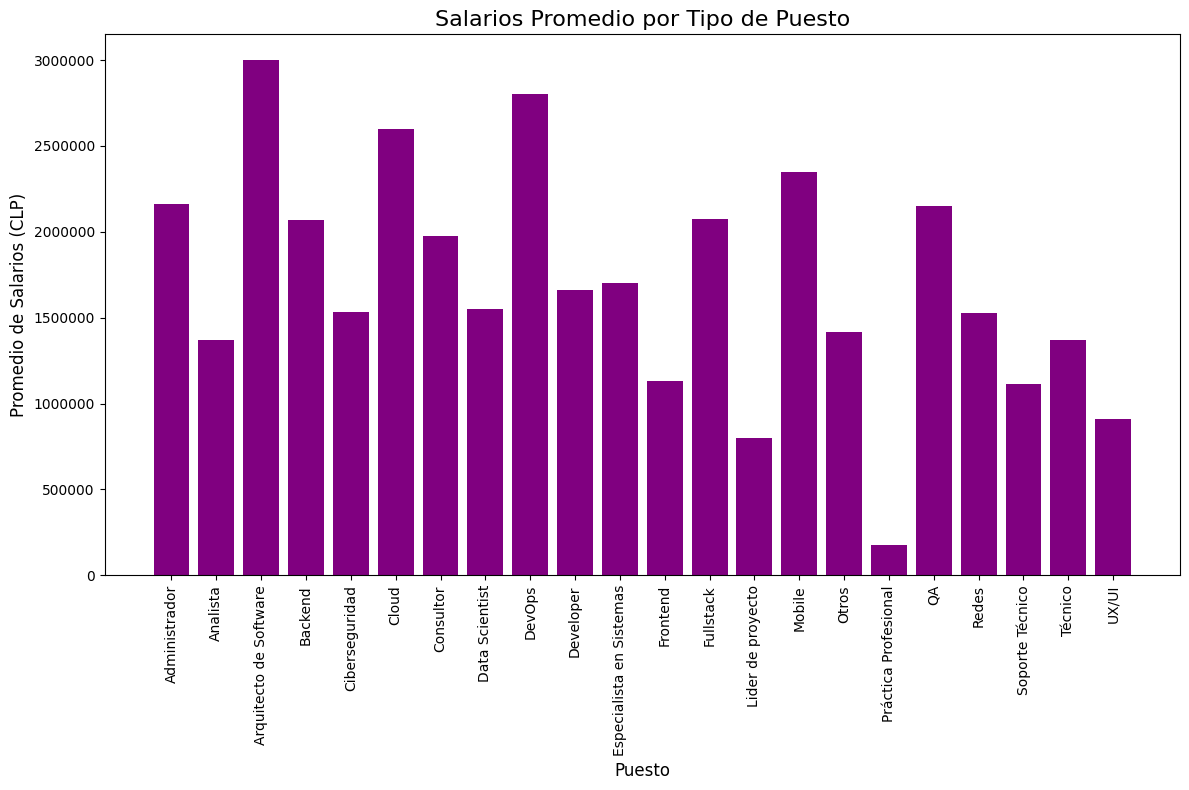

In [13]:
# Gráfico de salarios promedio por tipo de puesto
pltgr.figure(figsize=(12, 8))
pltgr.bar(promedio_salarios_puesto_total['Puesto'], promedio_salarios_puesto_total['Promedio_Salario'], color='purple')

# Configuración del gráfico
pltgr.title('Salarios Promedio por Tipo de Puesto', fontsize=16)
pltgr.xlabel('Puesto', fontsize=12)
pltgr.ylabel('Promedio de Salarios (CLP)', fontsize=12)
pltgr.xticks(rotation=90, fontsize=10)

# Evitar notación científica en el eje Y
pltgr.ticklabel_format(style='plain', axis='y')

pltgr.tight_layout()

# Mostrar el gráfico
pltgr.show()

In [14]:
# Concatenamos ambas tablas
tabla_total = pd.concat([tabla_puestos, tabla_puestos_comput,tabla_puestos_indeed])

# Agrupamos por 'Puesto' y sumamos las ofertas
tabla_total = tabla_total.groupby('Puesto', as_index=False).sum()

# Ordenamos de mayor a menor cantidad de ofertas
tabla_total = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla final
print("Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)\n")
tabla_total = tabla_total.sort_values(by='Puesto', ascending=True)
print(tabla_total.to_string(index=False))

Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)

                  Puesto  Cantidad_Ofertas
           Administrador                65
                Analista               305
  Arquitecto de Software                33
                 Backend                35
   Business Intelligence                 1
          Ciberseguridad                36
                   Cloud                46
               Consultor                80
          Data Scientist                60
                  DevOps                25
               Developer               214
Especialista en Sistemas                25
                Frontend                26
               Fullstack                58
       Lider de proyecto                17
                  Mobile                13
                   Otros              2530
    Práctica Profesional                42
                      QA                20
                   Redes                48
         Soporte Técnico     

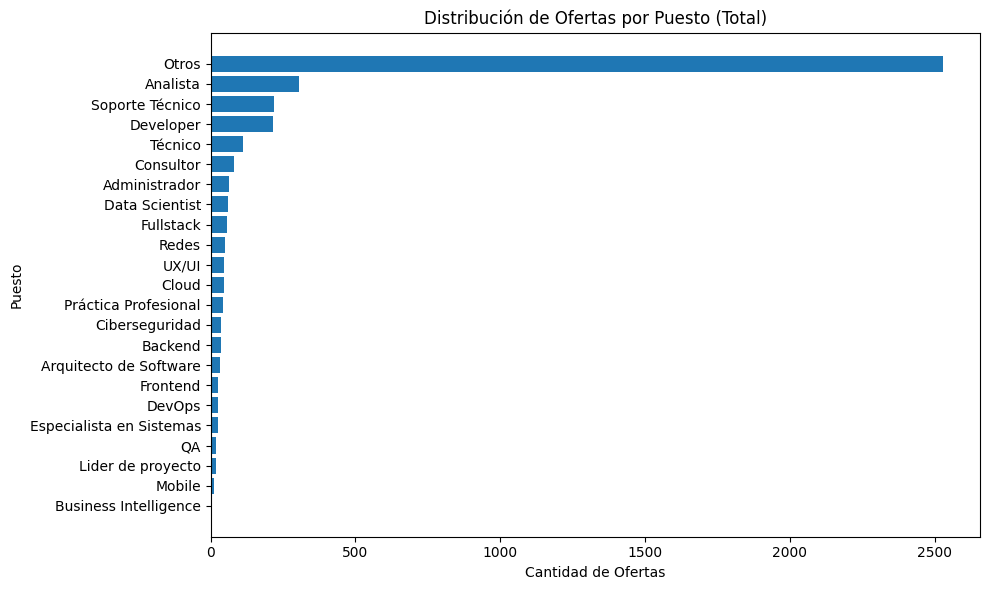

In [15]:
# Pie chart de puestos
tabla_total_sorted = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=True)

pltgr.figure(figsize=(10, 6))
pltgr.barh(tabla_total_sorted['Puesto'], tabla_total_sorted['Cantidad_Ofertas'])
pltgr.xlabel('Cantidad de Ofertas')
pltgr.ylabel('Puesto')
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()




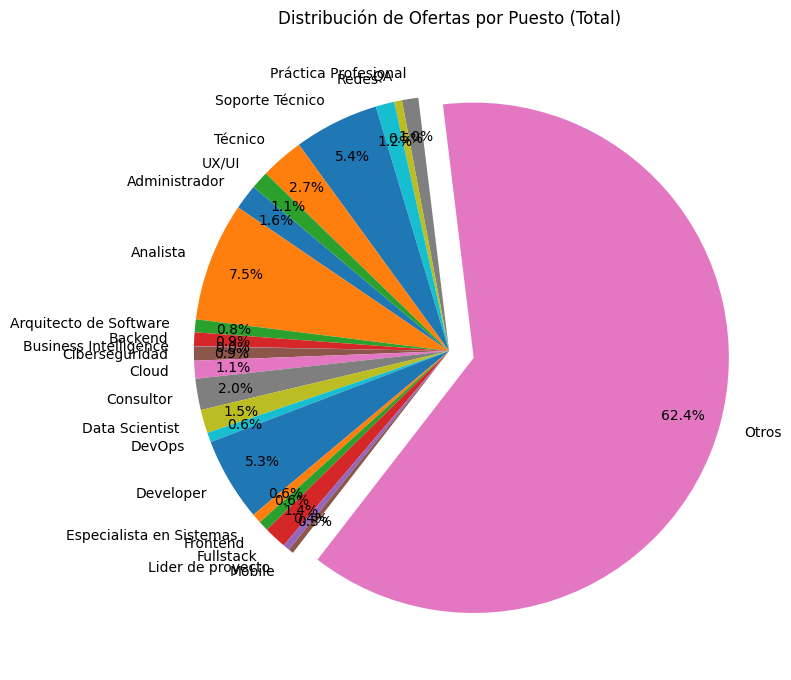

In [16]:

labels = tabla_total['Puesto']
sizes = tabla_total['Cantidad_Ofertas']

# Explode la categoría más grande (opcional)
explode = [0.1 if s == max(sizes) else 0 for s in sizes]

pltgr.figure(figsize=(8, 8))
pltgr.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    pctdistance=0.85,
    labeldistance=1.1
)
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()